## Prepare Dataset

In [12]:
import sys
sys.path.insert(1, '../datasets/')
from fasion_mnist import Dataset, DataLoader, TestDataloader
from fasion_mnist import IMAGE_SIZE, CHANNELS, BATCH_SIZE
dataset = Dataset()
dataloader = DataLoader()
test_dataloader = TestDataloader()

## Prepare Models

In [13]:
import importlib
import deq_model #import the module here, so that it can be reloaded.
importlib.reload(deq_model)
from deq_model import DEQ # or whatever name you want.

In [14]:
import torch
from torch.optim import Adam
from deq_model import DEQ

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DEQ(solver_type="anderson", channels = CHANNELS).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

## Hyper-parameters

In [15]:
save_and_sample_every = 1000
timesteps = 200
scheduler_type = "cosine"

from pathlib import Path
from schedulers import Scheduler
scheduler = Scheduler(scheduler_type, timesteps = timesteps)

## Evaluation

In [9]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups
from torch.utils.data import DataLoader, random_split
import time

import random
def evaluate (model):
    model.eval()
    total_loss = []
    start_time = time.time()
    
    for step, batch in enumerate(test_dataloader):
        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)
        t = torch.randint(0, scheduler.timesteps, (batch_size,), device=device).long()
        loss = p_losses(model, scheduler, batch, t, loss_type="huber")
        total_loss += [loss.item()]

    model.train()
    end_time = time.time()
    mean_loss = sum(total_loss) / len(total_loss)
    print(f'eval loss {mean_loss}, with run time {end_time - start_time}')
    return mean_loss

In [10]:
deq = []
for i in range (10):
    name = f'../weights/fasion_mnist_DEQ_anderson_24_ep{i}.pkl'
    model.load_state_dict(torch.load(name))
    loss = evaluate(model)
    deq.append(loss)

import pickle
with open('../stats/fasion_mnist_DEQ_anderson_24.pkl', 'wb') as f:
    pickle.dump(deq, f)

eval loss 0.07885499586221538, with run time 17.915499448776245
[] 0.07885499586221538
eval loss 0.06774539557061618, with run time 14.90221357345581
[0.07885499586221538] 0.06774539557061618
eval loss 0.06110637771743763, with run time 12.062571048736572
[0.07885499586221538, 0.06774539557061618] 0.06110637771743763
eval loss 0.05871354519755025, with run time 12.068068265914917
[0.07885499586221538, 0.06774539557061618, 0.06110637771743763] 0.05871354519755025
eval loss 0.057714751296782794, with run time 12.115832090377808
[0.07885499586221538, 0.06774539557061618, 0.06110637771743763, 0.05871354519755025] 0.057714751296782794
eval loss 0.05554790945747231, with run time 12.086266994476318
[0.07885499586221538, 0.06774539557061618, 0.06110637771743763, 0.05871354519755025, 0.057714751296782794] 0.05554790945747231
eval loss 0.08754467096509813, with run time 12.184159755706787
[0.07885499586221538, 0.06774539557061618, 0.06110637771743763, 0.05871354519755025, 0.057714751296782794, 

## Training

In [16]:
from torchvision.utils import save_image
from samplers import sample
from losses import p_losses
from utils import num_to_groups

def train (model, optimizer, scheduler, dataloader = dataloader, epochs=10, channels=CHANNELS):
    for epoch in range(epochs):
        epoch_loss = []
        for step, batch in enumerate(dataloader):
            batch_size = batch["pixel_values"].shape[0]
            optimizer.zero_grad()
            batch = batch["pixel_values"].to(device)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            t = torch.randint(0, scheduler.timesteps, (batch_size,), device=device).long()

            loss = p_losses(model, scheduler, batch, t, loss_type="huber")
            epoch_loss.append(loss.item())

            if step % 10 == 0:
                print("loss:", loss.item(), 'at step', step, ' out of ', len(dataloader))

            loss.backward()
            optimizer.step()

            # save generated images
            # if step != 0 and step % save_and_sample_every == 0:
            #     milestone = step // save_and_sample_every
            #     batches = num_to_groups(4, batch_size)
            #     all_images_list = list(map(lambda n: sample(model, scheduler, batch_size=n, channels=channels), batches))
            #     all_images = torch.cat(all_images_list, dim=0)
            #     all_images = (all_images + 1) * 0.5
            #     save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
        print(f'Loss after epoch {epoch}: {sum(epoch_loss) / len(epoch_loss)}')
        torch.save(model.state_dict(), f'../weights/fasion_mnist_DEQ_anderson_48_ep{epoch}.pkl')


In [17]:
train(model, optimizer, scheduler)

loss: 0.5952022075653076 at step 0  out of  469
loss: 0.11349361389875412 at step 10  out of  469
loss: 0.08691029250621796 at step 20  out of  469
loss: 0.08626861870288849 at step 30  out of  469
loss: 0.07981307059526443 at step 40  out of  469
loss: 0.07295376807451248 at step 50  out of  469
loss: 0.058810025453567505 at step 60  out of  469
loss: 0.06805825978517532 at step 70  out of  469
loss: 0.06898034363985062 at step 80  out of  469
loss: 0.07022331655025482 at step 90  out of  469
loss: 0.05684391036629677 at step 100  out of  469
loss: 0.05738816782832146 at step 110  out of  469
loss: 0.05522949621081352 at step 120  out of  469
loss: 0.05379842221736908 at step 130  out of  469
loss: 0.05342163145542145 at step 140  out of  469
loss: 0.0450308620929718 at step 150  out of  469
loss: 0.0470263808965683 at step 160  out of  469
loss: 0.052180446684360504 at step 170  out of  469
loss: 0.062197815626859665 at step 180  out of  469


KeyboardInterrupt: 

## Visualize & Eval

In [7]:
# import importlib
# import samplers
# import schedulers
# importlib.reload(samplers)
# importlib.reload(schedulers)
# from samplers import sample

In [8]:
from samplers import sample
%matplotlib inline
import matplotlib.pyplot as plt
# sample 64 images
samples = sample(model, scheduler, image_size=image_size, batch_size=64, channels=channels)
# print(f'shape of samples: {samples[-1].shape}')


sampling loop time step: 100%|██████████| 200/200 [00:06<00:00, 31.62it/s]


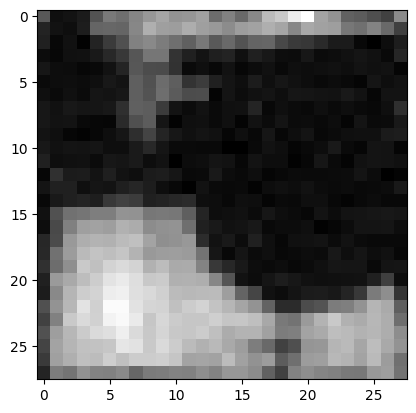

In [31]:

from random import randrange
random_index = randrange(0, 64)
# assert(samples[-1][random_index].shape == channels, image_size, image_size)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

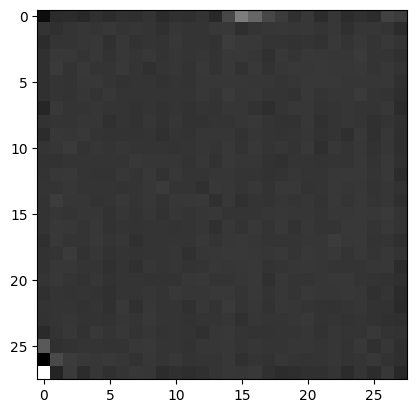

In [13]:
import matplotlib.animation as animation
%matplotlib inline
import matplotlib.pyplot as plt
from random import randrange

random_index = randrange(0, 64)

fig = plt.figure()
ims = []
for i in range(scheduler.timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# print(animate)
animate.save(f'diffusion_{random_index}.gif')
plt.show()